In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('C:/Users/Admin/Downloads/Gold Price.csv')

In [5]:
df.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,2014-01-01,29542,29435,29598,29340,2930,0.25
1,2014-01-02,29975,29678,30050,29678,3140,1.47
2,2014-01-03,29727,30031,30125,29539,3050,-0.83
3,2014-01-04,29279,29279,29279,29279,0,-1.51
4,2014-01-06,29119,29300,29395,29051,24380,-0.55


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2227 non-null   object 
 1   Price   2227 non-null   int64  
 2   Open    2227 non-null   int64  
 3   High    2227 non-null   int64  
 4   Low     2227 non-null   int64  
 5   Volume  2227 non-null   int64  
 6   Chg%    2227 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 121.9+ KB


In [9]:
df.describe()

,Price,Open,High,Low,Volume,Chg%
count,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000,2227.000000
mean,35217.900763,35222.369106,35417.074540,35019.329591,13508.495734,0.029070
std,8964.037211,8971.608761,9032.667462,8893.063733,11314.007396,0.857102
min,24545.000000,24583.000000,24635.000000,24470.000000,0.000000,-5.980000
25%,28554.500000,28531.000000,28659.000000,28417.500000,6680.000000,-0.400000
50%,30766.000000,30738.000000,30906.000000,30610.000000,11490.000000,0.020000
75%,45942.500000,45876.500000,46242.500000,45522.500000,17910.000000,0.460000
max,56117.000000,56351.000000,56499.000000,55400.000000,106920.000000,5.300000


In [11]:
df.shape

(2227, 7)

In [13]:
df.isnull().sum()

Date      0
Price     0
Open      0
High      0
Low       0
Volume    0
Chg%      0
dtype: int64

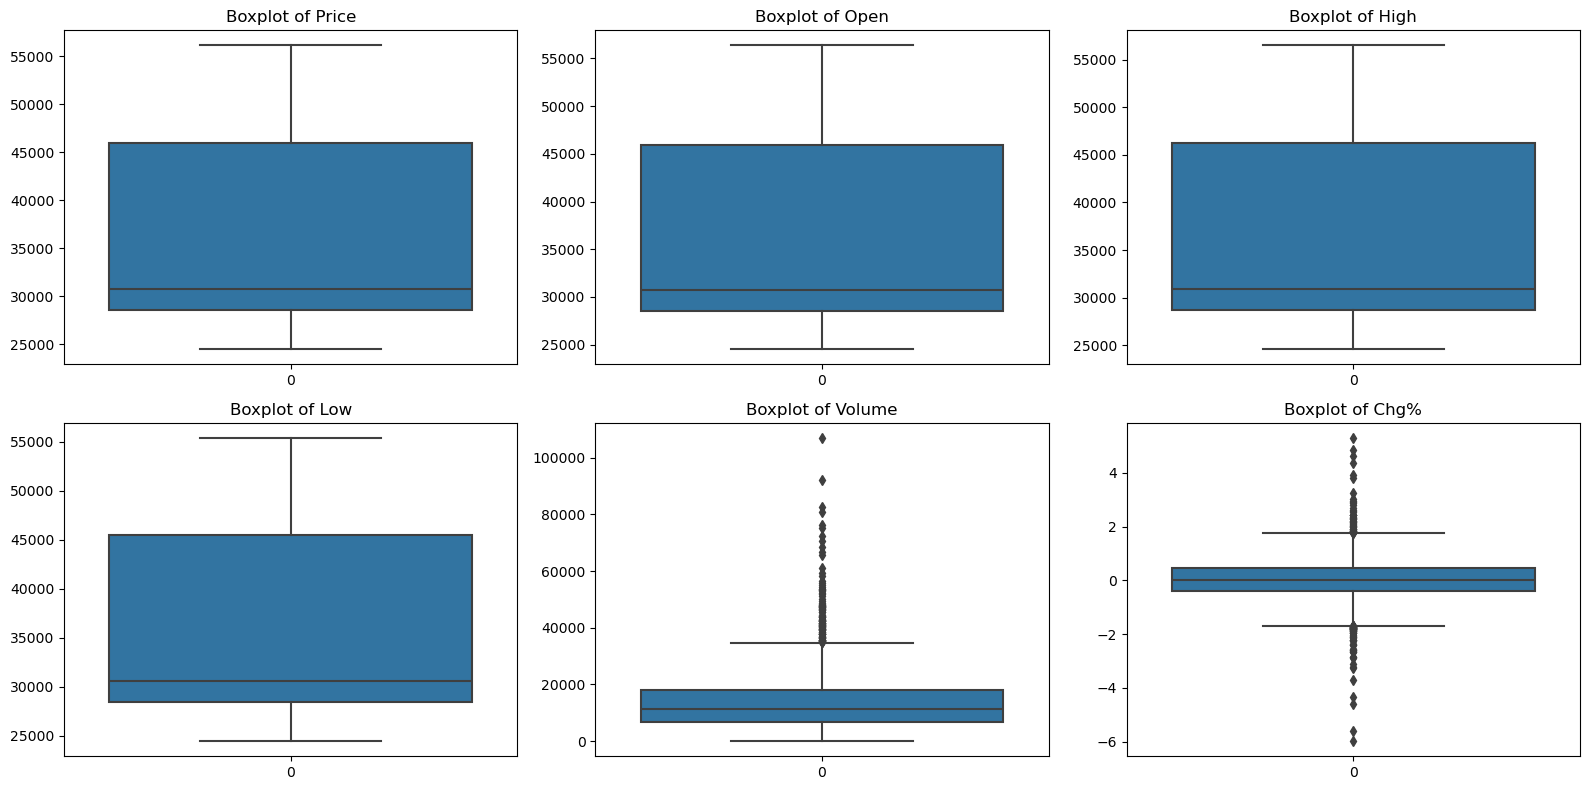

In [15]:
import seaborn as sns

# Visualize outliers using boxplots for each feature
features = ['Price', 'Open', 'High', 'Low', 'Volume', 'Chg%']
plt.figure(figsize=(16, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()


Number of outliers in Volume before handling: 108
Number of outliers in Chg% before handling: 112
Number of outliers in Volume after handling: 0
Number of outliers in Chg% after handling: 0


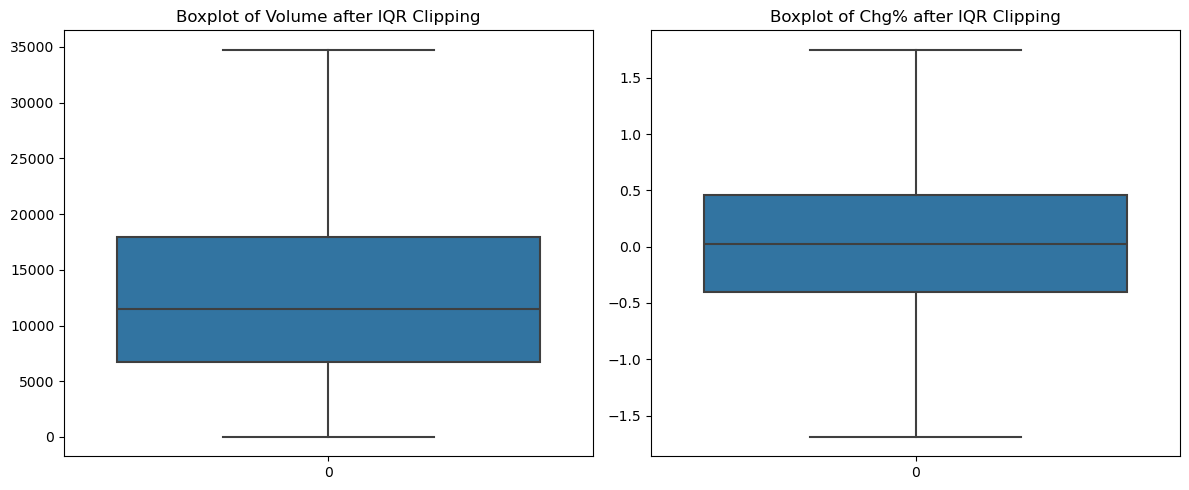

In [17]:
from scipy.stats import zscore
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers

# Count the number of outliers in Volume and Chg% before handling
volume_outliers_before = count_outliers(df['Volume'])
chg_outliers_before = count_outliers(df['Chg%'])

print(f'Number of outliers in Volume before handling: {len(volume_outliers_before)}')
print(f'Number of outliers in Chg% before handling: {len(chg_outliers_before)}')

# Handle outliers by clipping based on IQR
def clip_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower=lower_bound, upper=upper_bound)

df['Volume'] = clip_outliers(df['Volume'])
df['Chg%'] = clip_outliers(df['Chg%'])

# Count the number of outliers in Volume and Chg% after handling using the same method
volume_outliers_after = count_outliers(df['Volume'])
chg_outliers_after = count_outliers(df['Chg%'])

print(f'Number of outliers in Volume after handling: {len(volume_outliers_after)}')
print(f'Number of outliers in Chg% after handling: {len(chg_outliers_after)}')

# Visualize outliers using boxplots for Volume and Chg% after handling
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=df['Volume'])
plt.title('Boxplot of Volume after IQR Clipping')

plt.subplot(1, 2, 2)
sns.boxplot(data=df['Chg%'])
plt.title('Boxplot of Chg% after IQR Clipping')
plt.tight_layout()
plt.show()



In [21]:
# Convert the Date column to datetime and sort by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

In [23]:
# Create cyclical features for day of the year and day of the week
df['DayOfYear'] = df['Date'].dt.dayofyear
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Sin_DayOfYear'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
df['Cos_DayOfYear'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
df['Sin_DayOfWeek'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['Cos_DayOfWeek'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# Select features for training (including cyclical date features)
features = ['Open', 'High', 'Low', 'Volume', 'Chg%', 'Sin_DayOfYear', 'Cos_DayOfYear', 'Sin_DayOfWeek', 'Cos_DayOfWeek']

# Initialize the MinMaxScaler and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features])

# Function to create sequences
def create_sequences(df, seq_length):
    sequences = []
    targets = []
    for i in range(len(df) - seq_length):
        seq = df[i:i + seq_length]
        target = df[i + seq_length, 0]  # The 'Price' is the target (assumed to be the first column)
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)
# Include the price in the scaled_data for target extraction
scaled_data_with_price = scaler.fit_transform(df[['Price'] + features])
# Define sequence length (e.g., 30 days)
seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

# Include the price in the scaled_data for target extraction
scaled_data_with_price = scaler.fit_transform(df[['Price'] + features])
X, y = create_sequences(scaled_data_with_price, seq_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [25]:
# Build the RNN model with two RNN layers
model = Sequential()
model.add(SimpleRNN(50, input_shape=(seq_length, X.shape[2]), return_sequences=True))
model.add(SimpleRNN(30, return_sequences=False))
model.add(Dense(25, activation='linear'))
model.add(Dense(1,activation='linear'))  # Output layer to predict the price

model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=1000, validation_split=0.2)

# Evaluate the model on the test data
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

Epoch 1/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.1153 - val_loss: 0.1704
Epoch 2/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0060 - val_loss: 0.1024
Epoch 3/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026 - val_loss: 0.0354
Epoch 4/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014 - val_loss: 0.0168
Epoch 5/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.7717e-04 - val_loss: 0.0139
Epoch 6/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.5037e-04 - val_loss: 0.0069
Epoch 7/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.9863e-04 - val_loss: 0.0069
Epoch 8/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.2476e-04 - val_loss: 0.0064
Epoch 9/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.4020e-04 - val_loss: 0.0037
Epoch 10/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.4146e-04 - val_loss: 0.0045
Epoch 11/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.8584e-04 - val_loss: 0.0041
Epoch 12/100

In [ ]:
# Make predictions
from sklearn.metrics import r2_score
predictions = model.predict(X_test)

# Inverse transform the predictions and actual prices to get the original scale
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), X.shape[2]-1))), axis=1))[:,0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), X.shape[2]-1))), axis=1))[:,0]

# Calculate R-squared score
r2 = r2_score(y_test, predictions)
print(f'R-squared Score: {r2}')


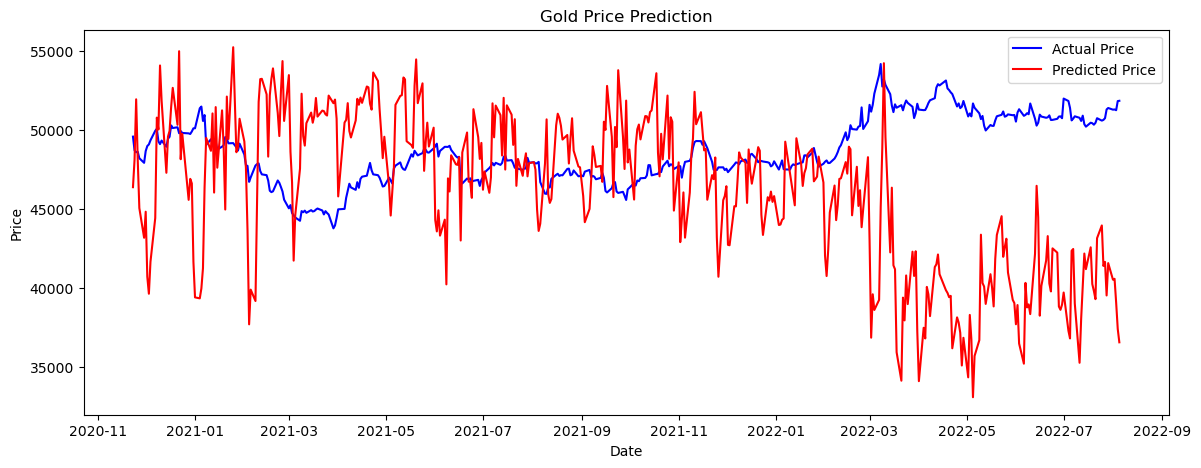

In [45]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(df['Date'].iloc[-len(y_test):], y_test, color='blue', label='Actual Price')
plt.plot(df['Date'].iloc[-len(predictions):], predictions, color='red', label='Predicted Price')
plt.title('Gold Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [47]:
# Save the model
model.save('simple_rnn_gold_price_model.h5')